In [31]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Sequential
import matplotlib.pyplot as plt
import json

# Base directory for dataset
base_dir = '/kaggle/input/plant-village-dataset-updated'

# Load datasets with inferred class labels
train_set = tf.keras.utils.image_dataset_from_directory(
    base_dir,  # Adjust this to your directory structure
    labels="inferred",
    label_mode="categorical",
    color_mode="rgb",
    batch_size=32,
    image_size=(128, 128),
    shuffle=True,
    subset="training",
    validation_split=0.2,
    seed=123
)

val_set = tf.keras.utils.image_dataset_from_directory(
    base_dir,  # Adjust this to your directory structure
    labels="inferred",
    label_mode="categorical",
    color_mode="rgb",
    batch_size=32,
    image_size=(128, 128),
    shuffle=True,
    subset="validation",
    validation_split=0.2,
    seed=123
)

Found 67118 files belonging to 9 classes.
Using 53695 files for training.
Found 67118 files belonging to 9 classes.
Using 13423 files for validation.


In [32]:
# EfficientNetB0 model for transfer learning
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Freeze the base model layers
base_model.trainable = False

# Build the custom model on top of EfficientNetB0
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(1024, activation='relu'),
    Dropout(0.5),
    Dense(len(train_set.class_names), activation='softmax')  # Number of classes in your dataset
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)          │ (None, 4, 4, 1280)          │       4,049,571 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_3           │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 1024)                │       1,311,744 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 9)                   │           9,225 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,370,540 (20.49 MB)

 Trainable params: 1,320,969 (5.04 MB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [33]:
# Training the model
history = model.fit(train_set, validation_data=val_set, epochs=10)

# Save the model and training history
model.save('/kaggle/working/efficientnet_plant_disease_model_final.keras')
with open('training_history.json', 'w') as f:
    json.dump(history.history, f)

# Evaluate the model on the validation set
test_loss, test_acc = model.evaluate(val_set)
print(f"Test Accuracy: {test_acc*100:.2f}%")

Epoch 1/10
1678/1678 ━━━━━━━━━━━━━━━━━━━━ 64s 28ms/step - accuracy: 0.8973 - loss: 0.3011 - val_accuracy: 0.9768 - val_loss: 0.0664
Epoch 2/10
1678/1678 ━━━━━━━━━━━━━━━━━━━━ 33s 19ms/step - accuracy: 0.9618 - loss: 0.1117 - val_accuracy: 0.9823 - val_loss: 0.0518
Epoch 3/10
1678/1678 ━━━━━━━━━━━━━━━━━━━━ 32s 19ms/step - accuracy: 0.9706 - loss: 0.0873 - val_accuracy: 0.9838 - val_loss: 0.0476
Epoch 4/10
1678/1678 ━━━━━━━━━━━━━━━━━━━━ 31s 19ms/step - accuracy: 0.9747 - loss: 0.0781 - val_accuracy: 0.9811 - val_loss: 0.0608
Epoch 5/10
1678/1678 ━━━━━━━━━━━━━━━━━━━━ 32s 19ms/step - accuracy: 0.9764 - loss: 0.0729 - val_accuracy: 0.9868 - val_loss: 0.0415
Epoch 6/10
1678/1678 ━━━━━━━━━━━━━━━━━━━━ 31s 19ms/step - accuracy: 0.9777 - loss: 0.0668 - val_accuracy: 0.9874 - val_loss: 0.0429
Epoch 7/10
1678/1678 ━━━━━━━━━━━━━━━━━━━━ 31s 19ms/step - accuracy: 0.9806 - loss: 0.0610 - val_accuracy: 0.9895 - val_loss: 0.0343
Epoch 8/10
1678/1678 ━━━━━━━━━━━━━━━━━━━━ 31s 19ms/step - accuracy: 0.9818 -

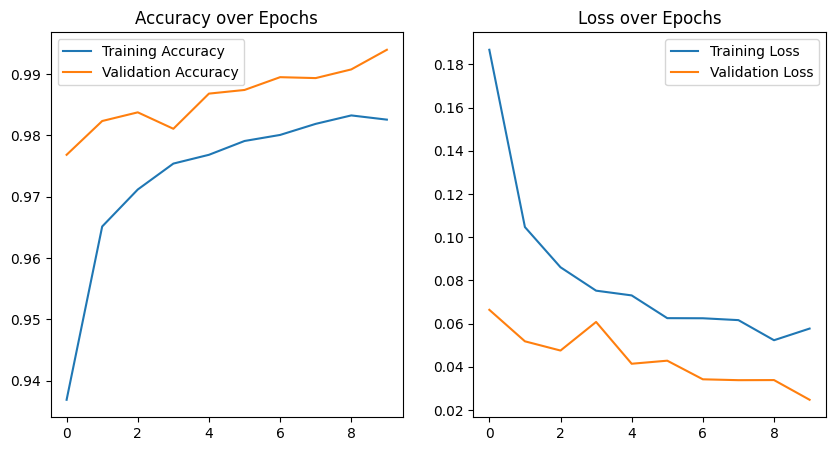

In [34]:
# Plotting training results
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.legend()
plt.show()

In [35]:
# Test set prediction using base_dir (inferred test set)
test_set = tf.keras.utils.image_dataset_from_directory(
    base_dir,  # Replace with the correct test path inside base_dir
    labels="inferred",
    label_mode="categorical",
    color_mode="rgb",
    batch_size=1,
    image_size=(128, 128),
    shuffle=False,
    seed=123
)

# Predicting with the trained model on the test set
y_pred = model.predict(test_set)

# Convert predictions to class labels (using argmax)
predicted_categories = tf.argmax(y_pred, axis=1)

# Print predicted categories
print(f"Predicted Categories: {predicted_categories.numpy()}")

Found 67118 files belonging to 9 classes.
67118/67118 ━━━━━━━━━━━━━━━━━━━━ 332s 5ms/step
Predicted Categories: [0 0 0 ... 8 8 8]
